In [ ]:
!pip install networkx pulp gurobipy ortools matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0


# Max Flow

## Individual solvers

In [ ]:
"""From Taha 'Introduction to Operations Research', example 6.4-2."""
import numpy as np

from ortools.graph.python import max_flow


def main():
    """MaxFlow simple interface example."""
    # Instantiate a SimpleMaxFlow solver.
    smf = max_flow.SimpleMaxFlow()

    # Define three parallel arrays: start_nodes, end_nodes, and the capacities
    # between each pair. For instance, the arc from node 0 to node 1 has a
    # capacity of 20.
    start_nodes = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
    end_nodes = np.array([1, 2, 3, 2, 4, 3, 4, 2, 4])
    capacities = np.array([20, 30, 10, 40, 30, 10, 20, 5, 20])

    # Add arcs in bulk.
    #   note: we could have used add_arc_with_capacity(start, end, capacity)
    all_arcs = smf.add_arcs_with_capacity(start_nodes, end_nodes, capacities)

    # Find the maximum flow between node 0 and node 4.
    status = smf.solve(0, 4)

    if status != smf.OPTIMAL:
        print("There was an issue with the max flow input.")
        print(f"Status: {status}")
        exit(1)
    print("Max flow:", smf.optimal_flow())
    print("")
    print(" Arc    Flow / Capacity")
    solution_flows = smf.flows(all_arcs)
    for arc, flow, capacity in zip(all_arcs, solution_flows, capacities):
        print(f"{smf.tail(arc)} / {smf.head(arc)}   {flow:3}  / {capacity:3}")
    print("Source side min-cut:", smf.get_source_side_min_cut())
    print("Sink side min-cut:", smf.get_sink_side_min_cut())


if __name__ == "__main__":
    main()

Max flow: 60

 Arc    Flow / Capacity
0 / 1    20  /  20
0 / 2    30  /  30
0 / 3    10  /  10
1 / 2     0  /  40
1 / 4    20  /  30
2 / 3    10  /  10
2 / 4    20  /  20
3 / 2     0  /   5
3 / 4    20  /  20
Source side min-cut: [0]
Sink side min-cut: [4, 1]


Max flow: 60
Source side min-cut: [0]
Sink side min-cut: [4, 1]


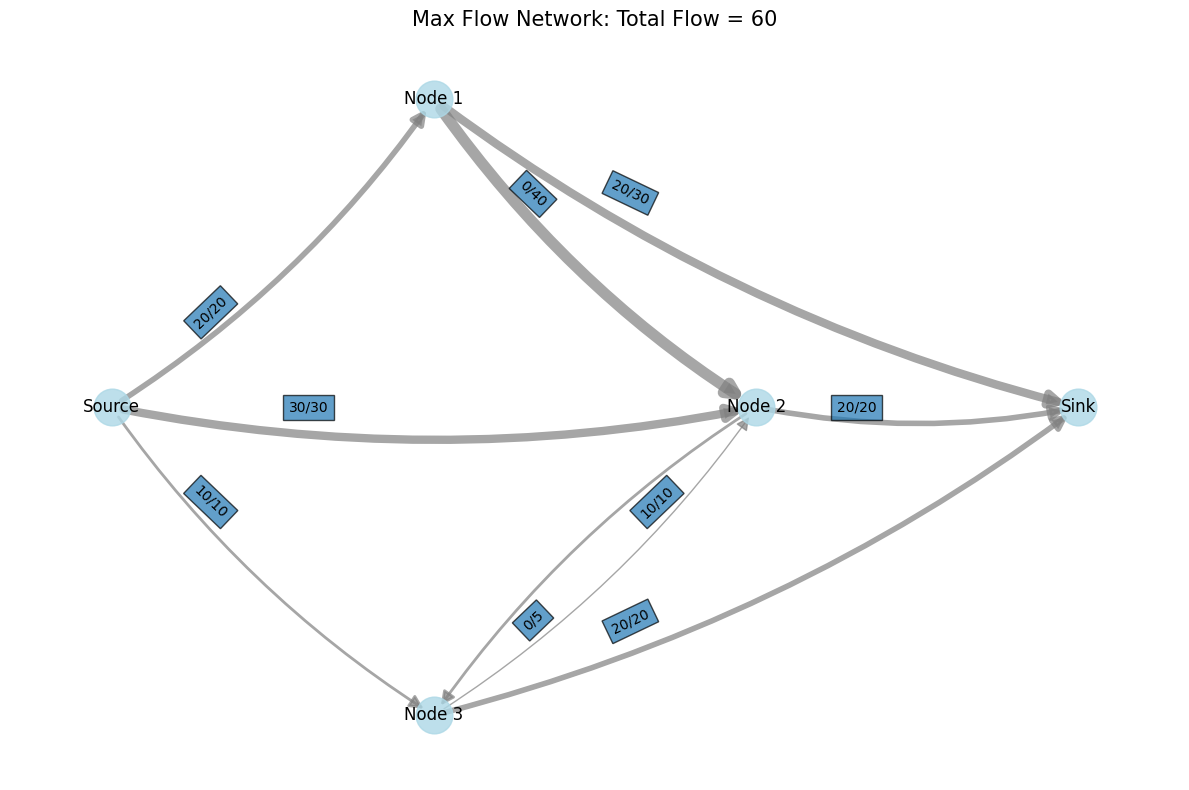

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from ortools.graph.python import max_flow

def create_flow_network_visualization():
    """Create a visualization of the max flow network from Taha example 6.4-2."""
    # Instantiate a SimpleMaxFlow solver
    smf = max_flow.SimpleMaxFlow()

    # Define the network structure
    start_nodes = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
    end_nodes = np.array([1, 2, 3, 2, 4, 3, 4, 2, 4])
    capacities = np.array([20, 30, 10, 40, 30, 10, 20, 5, 20])

    # Add arcs to the solver
    all_arcs = smf.add_arcs_with_capacity(start_nodes, end_nodes, capacities)

    # Find the maximum flow
    status = smf.solve(0, 4)

    if status != smf.OPTIMAL:
        print("There was an issue with the max flow input.")
        print(f"Status: {status}")
        return

    # Get flow values
    flows = smf.flows(all_arcs)

    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes with labels
    node_labels = {0: "Source", 4: "Sink"}
    for i in range(5):
        if i in node_labels:
            G.add_node(i, label=node_labels[i])
        else:
            G.add_node(i, label=f"Node {i}")

    # Add edges with flow/capacity labels
    for i, (start, end, capacity, flow) in enumerate(zip(start_nodes, end_nodes, capacities, flows)):
        G.add_edge(start, end, capacity=capacity, flow=flow, weight=capacity)

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Define node positions for better visualization
    # Using a hierarchical layout from left to right
    pos = {
        0: (0, 0),    # Source
        1: (1, 1),    # Node 1
        2: (2, 0),    # Node 2
        3: (1, -1),   # Node 3
        4: (3, 0)     # Sink
    }

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color="lightblue", alpha=0.8)

    # Draw node labels
    node_labels = {node: data["label"] for node, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

    # Draw edges with different widths based on capacity
    edge_widths = [data["weight"]/5 for u, v, data in G.edges(data=True)]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.7, edge_color="gray",
                          arrowsize=20, connectionstyle='arc3,rad=0.1')

    # Create edge labels showing flow/capacity
    edge_labels = {(u, v): f"{data['flow']}/{data['capacity']}"
                   for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10,
                                label_pos=0.3, bbox={"alpha": 0.7})

    # Set title and display the plot
    plt.title(f"Max Flow Network: Total Flow = {smf.optimal_flow()}", fontsize=15)
    plt.axis("off")
    plt.tight_layout()

    # Print the min-cut information
    source_side = smf.get_source_side_min_cut()
    sink_side = smf.get_sink_side_min_cut()
    print(f"Max flow: {smf.optimal_flow()}")
    print(f"Source side min-cut: {source_side}")
    print(f"Sink side min-cut: {sink_side}")

    plt.savefig("max_flow_network.png", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    create_flow_network_visualization()

=== Solving with PuLP ===
Status: Optimal
Maximum flow: 60.0

Flow on each arc:
Arc (0 → 1): 20.0 / 20
Arc (0 → 2): 30.0 / 30
Arc (0 → 3): 10.0 / 10
Arc (1 → 4): 20.0 / 30
Arc (2 → 3): 10.0 / 10
Arc (2 → 4): 20.0 / 20
Arc (3 → 4): 20.0 / 20


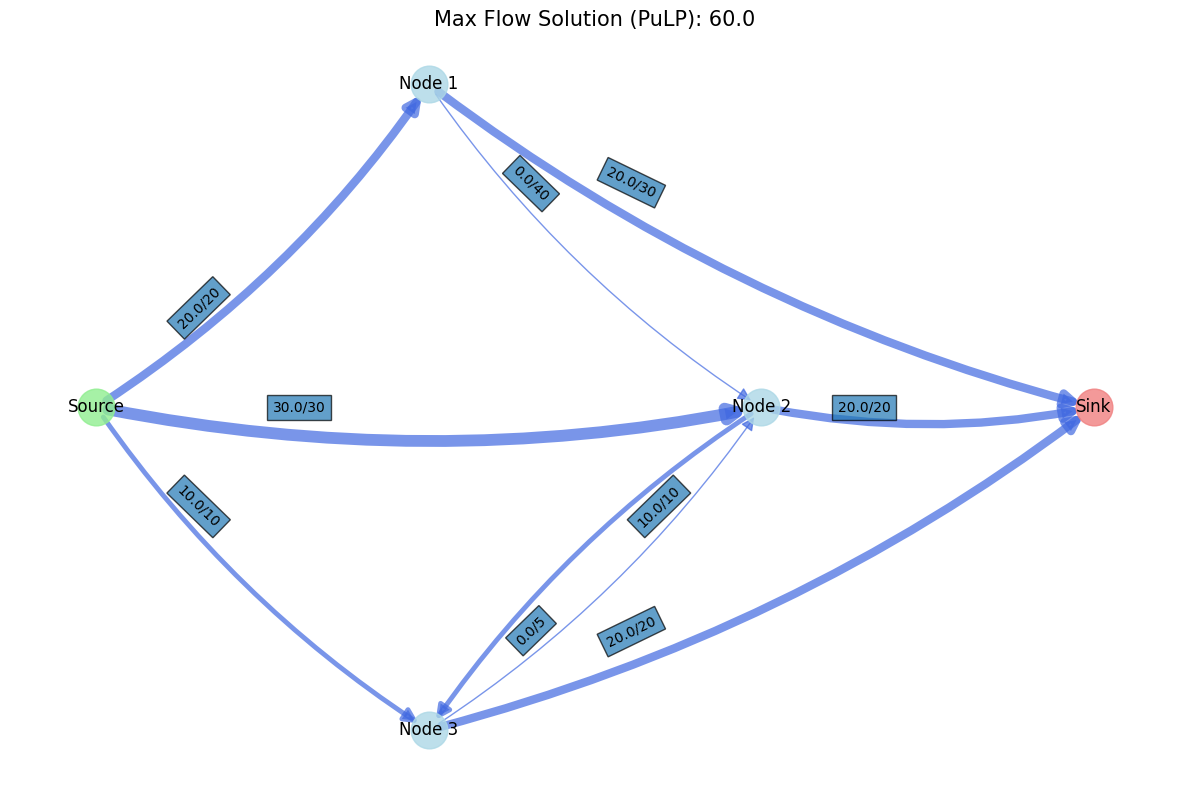


=== Solving with Gurobi ===
Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 3 rows, 9 columns and 12 nonzeros
Model fingerprint: 0xd71b0bff
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e+00, 4e+01]
  RHS range        [0e+00, 0e+00]
Presolve removed 2 rows and 4 columns
Presolve time: 0.01s
Presolved: 1 rows, 5 columns, 5 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    6.0000000e+01   3.000000e+01   0.000000e+00      0s
       2    6.0000000e+01   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.000000000e+01
Maximum flow: 60.0

Flow on each arc:
Arc (0 → 1):

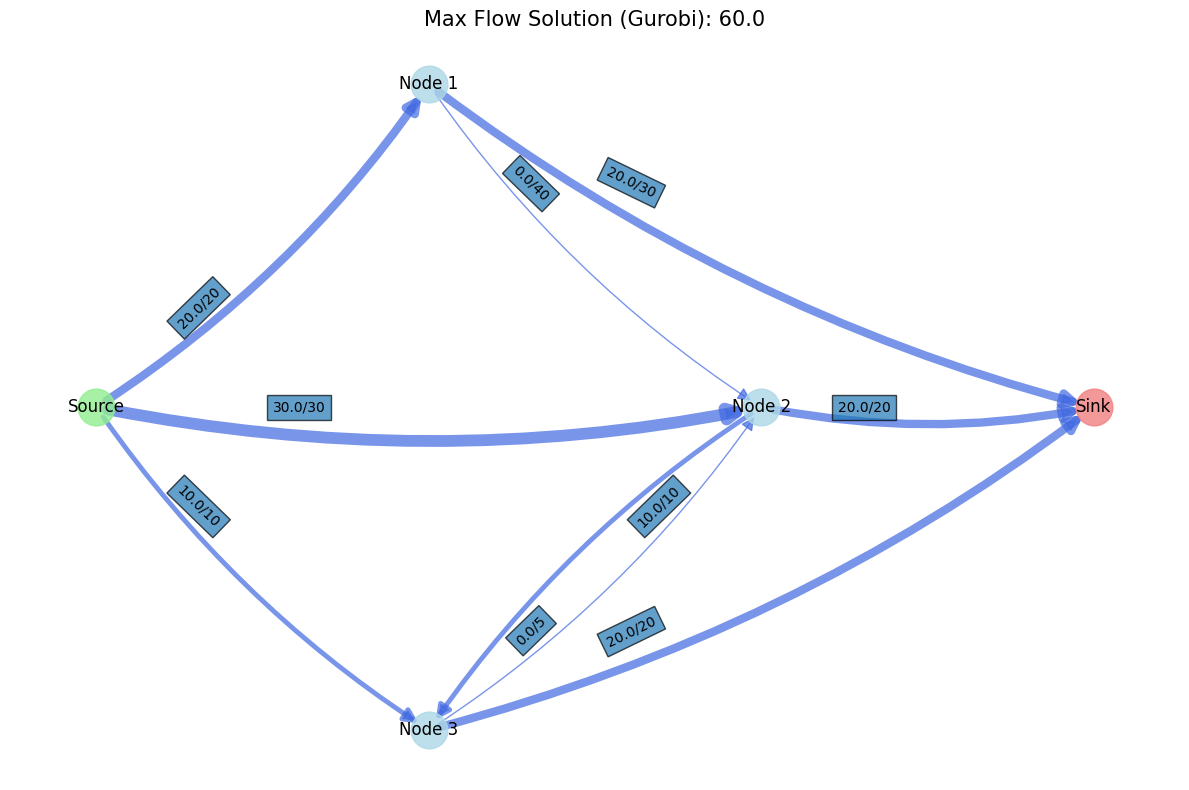

In [ ]:
import numpy as np
import pulp
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import matplotlib.pyplot as plt

def solve_max_flow_pulp():
    """Solve the maximum flow problem using PuLP."""
    print("=== Solving with PuLP ===")

    # Define the problem data
    start_nodes = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
    end_nodes = np.array([1, 2, 3, 2, 4, 3, 4, 2, 4])
    capacities = np.array([20, 30, 10, 40, 30, 10, 20, 5, 20])

    # Create a directed graph
    G = nx.DiGraph()
    for start, end, cap in zip(start_nodes, end_nodes, capacities):
        G.add_edge(start, end, capacity=cap)

    # Create a PuLP problem
    prob = pulp.LpProblem("Maximum_Flow", pulp.LpMaximize)

    # Create flow variables for each edge
    flow_vars = {}
    for u, v, data in G.edges(data=True):
        flow_vars[(u, v)] = pulp.LpVariable(f"flow_{u}_{v}", lowBound=0, upBound=data['capacity'])

    # Source and sink nodes
    source = 0
    sink = 4

    # Define the objective: maximize the flow out of the source
    prob += pulp.lpSum(flow_vars[(source, v)] for v in G.successors(source)), "Maximize_Flow"

    # Add flow conservation constraints
    for node in G.nodes():
        if node != source and node != sink:
            # Flow in equals flow out for all nodes except source and sink
            prob += (
                pulp.lpSum(flow_vars[(u, node)] for u in G.predecessors(node)) ==
                pulp.lpSum(flow_vars[(node, v)] for v in G.successors(node)),
                f"Conservation_{node}"
            )

    # Solve the problem
    prob.solve()

    # Print results
    print(f"Status: {pulp.LpStatus[prob.status]}")
    if prob.status == pulp.LpStatusOptimal:
        print(f"Maximum flow: {pulp.value(prob.objective)}")
        print("\nFlow on each arc:")
        for (u, v), var in flow_vars.items():
            if pulp.value(var) > 0:
                print(f"Arc ({u} → {v}): {pulp.value(var)} / {G.edges[u, v]['capacity']}")

        # Return flow values for visualization
        flows = {}
        for (u, v), var in flow_vars.items():
            flows[(u, v)] = pulp.value(var)
        return pulp.value(prob.objective), flows

    return None, None


def solve_max_flow_gurobi():
    """Solve the maximum flow problem using Gurobi."""
    print("\n=== Solving with Gurobi ===")

    # Define the problem data
    start_nodes = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
    end_nodes = np.array([1, 2, 3, 2, 4, 3, 4, 2, 4])
    capacities = np.array([20, 30, 10, 40, 30, 10, 20, 5, 20])

    # Create a directed graph
    G = nx.DiGraph()
    for start, end, cap in zip(start_nodes, end_nodes, capacities):
        G.add_edge(start, end, capacity=cap)

    try:
        # Create a Gurobi model
        model = gp.Model("Maximum_Flow")

        # Create flow variables for each edge
        flow_vars = {}
        for u, v, data in G.edges(data=True):
            flow_vars[(u, v)] = model.addVar(
                name=f"flow_{u}_{v}",
                lb=0,
                ub=data['capacity']
            )

        # Source and sink nodes
        source = 0
        sink = 4

        # Define the objective: maximize the flow out of the source
        model.setObjective(
            gp.quicksum(flow_vars[(source, v)] for v in G.successors(source)),
            GRB.MAXIMIZE
        )

        # Add flow conservation constraints
        for node in G.nodes():
            if node != source and node != sink:
                # Flow in equals flow out for all nodes except source and sink
                model.addConstr(
                    gp.quicksum(flow_vars[(u, node)] for u in G.predecessors(node)) ==
                    gp.quicksum(flow_vars[(node, v)] for v in G.successors(node)),
                    name=f"Conservation_{node}"
                )

        # Optimize the model
        model.optimize()

        # Print results
        if model.status == GRB.OPTIMAL:
            print(f"Maximum flow: {model.objVal}")
            print("\nFlow on each arc:")
            for (u, v), var in flow_vars.items():
                if var.x > 0:
                    print(f"Arc ({u} → {v}): {var.x} / {G.edges[u, v]['capacity']}")

            # Return flow values for visualization
            flows = {}
            for (u, v), var in flow_vars.items():
                flows[(u, v)] = var.x
            return model.objVal, flows
        else:
            print(f"Optimization was stopped with status {model.status}")
            return None, None

    except gp.GurobiError as e:
        print(f"Error code {e.errno}: {e}")
        return None, None


def visualize_max_flow(flows, solver_name):
    """Visualize the max flow solution."""
    # Define the problem data
    start_nodes = np.array([0, 0, 0, 1, 1, 2, 2, 3, 3])
    end_nodes = np.array([1, 2, 3, 2, 4, 3, 4, 2, 4])
    capacities = np.array([20, 30, 10, 40, 30, 10, 20, 5, 20])

    # Create a directed graph
    G = nx.DiGraph()
    for start, end, cap in zip(start_nodes, end_nodes, capacities):
        G.add_edge(start, end, capacity=cap, flow=flows.get((start, end), 0))

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Define node positions for better visualization
    pos = {
        0: (0, 0),    # Source
        1: (1, 1),    # Node 1
        2: (2, 0),    # Node 2
        3: (1, -1),   # Node 3
        4: (3, 0)     # Sink
    }

    # Draw nodes
    node_labels = {0: "Source", 4: "Sink"}
    for i in range(5):
        if i in node_labels:
            nx.draw_networkx_nodes(G, pos, nodelist=[i], node_size=700,
                                 node_color="lightgreen" if i == 0 else "lightcoral", alpha=0.8)
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=[i], node_size=700,
                                 node_color="lightblue", alpha=0.8)

    # Draw node labels
    labels = {i: node_labels.get(i, f"Node {i}") for i in range(5)}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

    # Draw edges with different widths based on flow
    for u, v, data in G.edges(data=True):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                              width=1 + data['flow']/4,
                              alpha=0.7,
                              edge_color="royalblue",
                              arrowsize=20,
                              connectionstyle='arc3,rad=0.1')

    # Create edge labels showing flow/capacity
    edge_labels = {(u, v): f"{data['flow']}/{data['capacity']}"
                  for u, v, data in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10,
                               label_pos=0.3, bbox={"alpha": 0.7})

    # Add title and display
    max_flow_value = sum(flows.get((0, v), 0) for v in G.successors(0))
    plt.title(f"Max Flow Solution ({solver_name}): {max_flow_value}", fontsize=15)
    plt.axis("off")
    plt.tight_layout()

    plt.savefig(f"max_flow_{solver_name.lower()}.png", dpi=300, bbox_inches="tight")
    plt.show()


def main():
    # Solve with PuLP
    pulp_value, pulp_flows = solve_max_flow_pulp()
    if pulp_flows:
        visualize_max_flow(pulp_flows, "PuLP")

    # Solve with Gurobi
    gurobi_value, gurobi_flows = solve_max_flow_gurobi()
    if gurobi_flows:
        visualize_max_flow(gurobi_flows, "Gurobi")


if __name__ == "__main__":
    main()

## Comparison

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import random
from ortools.graph.python import max_flow
import pulp
import gurobipy as gp
from gurobipy import GRB

def generate_random_network(n_nodes, density=0.3, max_capacity=100):
    """Generate a random flow network with n_nodes nodes.

    Args:
        n_nodes: Number of nodes in the network
        density: Probability of edge creation between any two nodes
        max_capacity: Maximum capacity of any edge

    Returns:
        A tuple of (start_nodes, end_nodes, capacities) arrays
    """
    G = nx.DiGraph()

    # Add nodes
    for i in range(n_nodes):
        G.add_node(i)

    # Add random edges (excluding edges to source and from sink)
    source = 0
    sink = n_nodes - 1

    start_nodes = []
    end_nodes = []
    capacities = []

    for i in range(n_nodes):
        for j in range(n_nodes):
            # Skip self-loops and edges into source or out of sink
            if (i != j and j != source and i != sink):
                if random.random() < density:
                    capacity = random.randint(1, max_capacity)
                    G.add_edge(i, j, capacity=capacity)
                    start_nodes.append(i)
                    end_nodes.append(j)
                    capacities.append(capacity)

    # Ensure the source has outgoing edges and sink has incoming edges
    # to guarantee a feasible flow problem
    if not list(G.successors(source)):
        # Add at least one edge from source
        target = random.randint(1, n_nodes-2)
        capacity = random.randint(1, max_capacity)
        G.add_edge(source, target, capacity=capacity)
        start_nodes.append(source)
        end_nodes.append(target)
        capacities.append(capacity)

    if not list(G.predecessors(sink)):
        # Add at least one edge to sink
        origin = random.randint(1, n_nodes-2)
        capacity = random.randint(1, max_capacity)
        G.add_edge(origin, sink, capacity=capacity)
        start_nodes.append(origin)
        end_nodes.append(sink)
        capacities.append(capacity)

    return np.array(start_nodes), np.array(end_nodes), np.array(capacities)

def solve_with_ortools(start_nodes, end_nodes, capacities, source, sink):
    """Solve max flow using Google OR-Tools."""
    start_time = time.time()

    # Create the solver
    smf = max_flow.SimpleMaxFlow()

    # Add arcs
    smf.add_arcs_with_capacity(start_nodes, end_nodes, capacities)

    # Find the maximum flow
    status = smf.solve(source, sink)

    end_time = time.time()

    if status == smf.OPTIMAL:
        max_flow_value = smf.optimal_flow()
        return max_flow_value, end_time - start_time
    else:
        print(f"OR-Tools failed with status: {status}")
        return None, end_time - start_time

def solve_with_pulp(start_nodes, end_nodes, capacities, source, sink):
    """Solve max flow using PuLP."""
    start_time = time.time()

    # Create a directed graph
    G = nx.DiGraph()
    for start, end, cap in zip(start_nodes, end_nodes, capacities):
        G.add_edge(start, end, capacity=cap)

    # Create a PuLP problem
    prob = pulp.LpProblem("Maximum_Flow", pulp.LpMaximize)

    # Create flow variables for each edge
    flow_vars = {}
    for u, v, data in G.edges(data=True):
        flow_vars[(u, v)] = pulp.LpVariable(f"flow_{u}_{v}", lowBound=0, upBound=data['capacity'])

    # Define the objective: maximize the flow out of the source
    prob += pulp.lpSum(flow_vars[(source, v)] for v in G.successors(source)), "Maximize_Flow"

    # Add flow conservation constraints
    for node in G.nodes():
        if node != source and node != sink:
            incoming = [flow_vars[(u, node)] for u in G.predecessors(node)] if list(G.predecessors(node)) else [0]
            outgoing = [flow_vars[(node, v)] for v in G.successors(node)] if list(G.successors(node)) else [0]
            # Flow in equals flow out for all nodes except source and sink
            prob += pulp.lpSum(incoming) == pulp.lpSum(outgoing), f"Conservation_{node}"

    # Solve the problem (using CBC solver which is the default)
    prob.solve(pulp.PULP_CBC_CMD(msg=False))

    end_time = time.time()

    if prob.status == pulp.LpStatusOptimal:
        max_flow_value = pulp.value(prob.objective)
        return max_flow_value, end_time - start_time
    else:
        print(f"PuLP failed with status: {pulp.LpStatus[prob.status]}")
        return None, end_time - start_time

def solve_with_gurobi(start_nodes, end_nodes, capacities, source, sink):
    """Solve max flow using Gurobi."""
    start_time = time.time()

    try:
        # Create a directed graph
        G = nx.DiGraph()
        for start, end, cap in zip(start_nodes, end_nodes, capacities):
            G.add_edge(start, end, capacity=cap)

        # Create a Gurobi model
        model = gp.Model("Maximum_Flow")
        model.setParam('OutputFlag', 0)  # Suppress output

        # Create flow variables for each edge
        flow_vars = {}
        for u, v, data in G.edges(data=True):
            flow_vars[(u, v)] = model.addVar(
                name=f"flow_{u}_{v}",
                lb=0,
                ub=data['capacity']
            )

        # Define the objective: maximize the flow out of the source
        outflow = [flow_vars[(source, v)] for v in G.successors(source)] if list(G.successors(source)) else [0]
        model.setObjective(gp.quicksum(outflow), GRB.MAXIMIZE)

        # Add flow conservation constraints
        for node in G.nodes():
            if node != source and node != sink:
                incoming = [flow_vars[(u, node)] for u in G.predecessors(node)] if list(G.predecessors(node)) else [0]
                outgoing = [flow_vars[(node, v)] for v in G.successors(node)] if list(G.successors(node)) else [0]

                # Flow in equals flow out for all nodes except source and sink
                if len(incoming) > 0 and len(outgoing) > 0:
                    model.addConstr(gp.quicksum(incoming) == gp.quicksum(outgoing), name=f"Conservation_{node}")

        # Optimize the model
        model.optimize()

        end_time = time.time()

        if model.status == GRB.OPTIMAL:
            max_flow_value = model.objVal
            return max_flow_value, end_time - start_time
        else:
            print(f"Gurobi failed with status: {model.status}")
            return None, end_time - start_time

    except gp.GurobiError as e:
        end_time = time.time()
        print(f"Gurobi error: {e}")
        return None, end_time - start_time


Testing with 10 nodes...
Testing with 20 nodes...
Testing with 30 nodes...
Testing with 40 nodes...
Testing with 50 nodes...
Testing with 60 nodes...
Testing with 70 nodes...
Testing with 80 nodes...
Testing with 90 nodes...
Testing with 100 nodes...

Performance Results:
   nodes       edges  ortools_time  pulp_time  gurobi_time
0     10   24.333333      0.000211   0.012471     0.001942
1     20   82.333333      0.000153   0.010856     0.002739
2     30  136.000000      0.000163   0.012208     0.003405
3     40  190.000000      0.000154   0.013647     0.004469
4     50  231.666667      0.000164   0.018186     0.005603
5     60  351.333333      0.000178   0.018719     0.006142
6     70  470.666667      0.000164   0.021877     0.008373
7     80  630.000000      0.000223   0.029106     0.011956
8     90  783.666667      0.000237   0.033922     0.012409
9    100  965.666667      0.000307   0.043891     0.014626


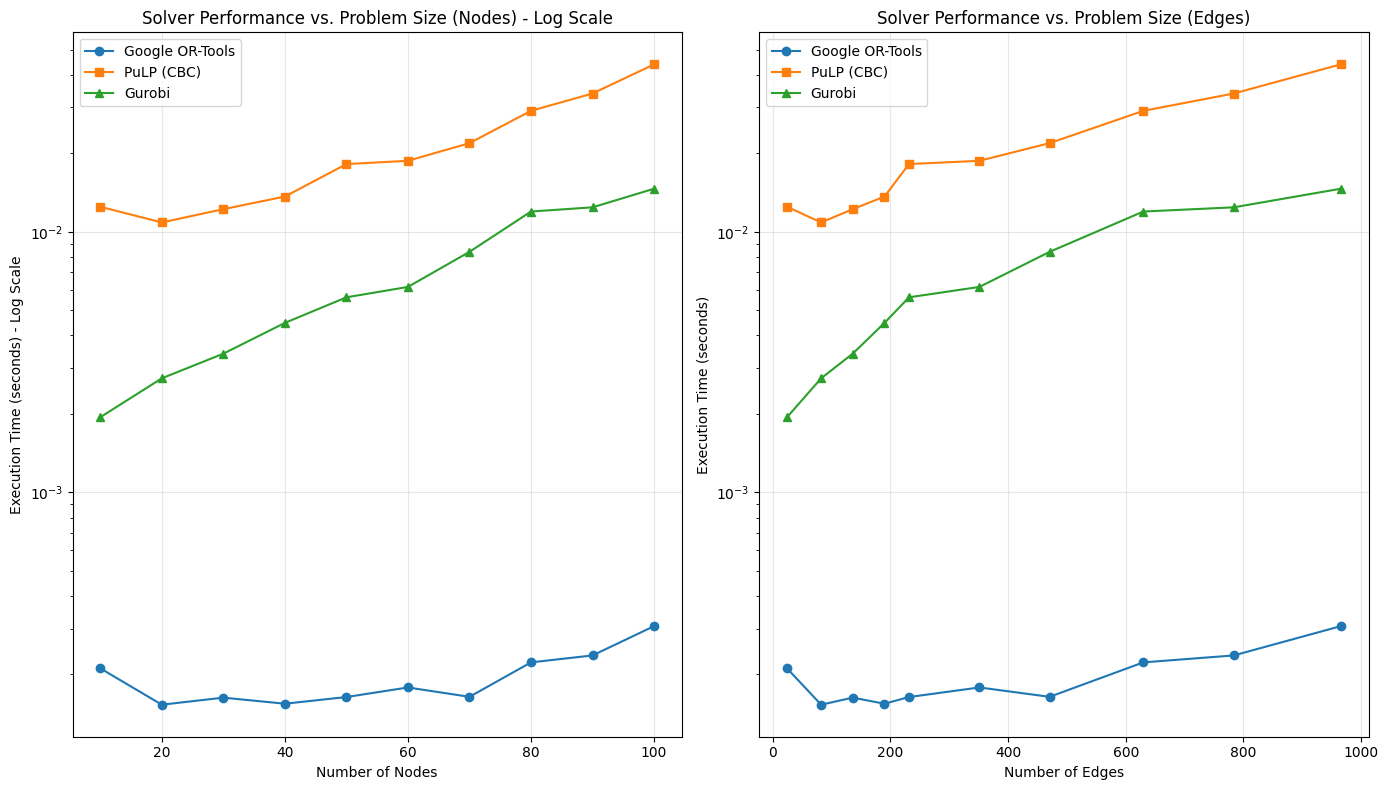

In [ ]:

def compare_solvers_performance():
    """Compare performance of different solvers for maximum flow problems."""
    # Problem sizes to test
    node_counts = list(range(10, 101, 10))  # 10, 20, ..., 100 nodes

    # Number of trials per size
    num_trials = 3

    # Dictionary to store results
    results = {
        'nodes': [],
        'edges': [],
        'ortools_time': [],
        'pulp_time': [],
        'gurobi_time':[]
    }

    for n_nodes in node_counts:
        print(f"Testing with {n_nodes} nodes...")

        ortools_times = []
        pulp_times = []
        gurobi_times = []
        edge_counts = []

        for trial in range(num_trials):
            # Generate a random network
            # For larger networks, reduce density to avoid too many edges
            density = max(0.1, min(0.3, 5 / n_nodes))
            start_nodes, end_nodes, capacities = generate_random_network(n_nodes, density=density)
            edge_counts.append(len(start_nodes))

            source = 0
            sink = n_nodes - 1

            # Solve with OR-Tools
            _, ortools_time = solve_with_ortools(start_nodes, end_nodes, capacities, source, sink)
            ortools_times.append(ortools_time)

            # Solve with PuLP
            _, pulp_time = solve_with_pulp(start_nodes, end_nodes, capacities, source, sink)
            pulp_times.append(pulp_time)

            # Solve with Gurobi
            _, gurobi_time = solve_with_gurobi(start_nodes, end_nodes, capacities, source, sink)
            gurobi_times.append(gurobi_time)

        # Store average results for this problem size
        results['nodes'].append(n_nodes)
        results['edges'].append(np.mean(edge_counts))
        results['ortools_time'].append(np.mean(ortools_times))
        results['pulp_time'].append(np.mean(pulp_times))
        results['gurobi_time'].append(np.mean(gurobi_times))

    return pd.DataFrame(results)

def plot_performance_comparison(results):
    """Plot the performance comparison results."""
    # plt.figure(figsize=(14, 8))

    # # Plot times vs nodes
    # plt.subplot(1, 2, 1)
    # plt.plot(results['nodes'], results['ortools_time'], 'o-', label='Google OR-Tools')
    # plt.plot(results['nodes'], results['pulp_time'], 's-', label='PuLP (CBC)')
    # plt.plot(results['nodes'], results['gurobi_time'], '^-', label='Gurobi')
    # plt.xlabel('Number of Nodes')
    # plt.ylabel('Execution Time (seconds)')
    # plt.title('Solver Performance vs. Problem Size (Nodes)')
    # plt.grid(True, alpha=0.3)
    # plt.legend()

    # # Plot times vs edges
    # plt.subplot(1, 2, 2)
    # plt.plot(results['edges'], results['ortools_time'], 'o-', label='Google OR-Tools')
    # plt.plot(results['edges'], results['pulp_time'], 's-', label='PuLP (CBC)')
    # plt.plot(results['edges'], results['gurobi_time'], '^-', label='Gurobi')
    # plt.xlabel('Number of Edges')
    # plt.ylabel('Execution Time (seconds)')
    # plt.title('Solver Performance vs. Problem Size (Edges)')
    # plt.grid(True, alpha=0.3)
    # plt.legend()

    # plt.tight_layout()
    # plt.savefig('max_flow_performance_comparison.png', dpi=300, bbox_inches='tight')
    # plt.show()

    # Also create a log-scale plot for better visualization of differences
    plt.figure(figsize=(14, 8))

    # Plot log times vs nodes
    plt.subplot(1, 2, 1)
    plt.semilogy(results['nodes'], results['ortools_time'], 'o-', label='Google OR-Tools')
    plt.semilogy(results['nodes'], results['pulp_time'], 's-', label='PuLP (CBC)')
    plt.semilogy(results['nodes'], results['gurobi_time'], '^-', label='Gurobi')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Execution Time (seconds) - Log Scale')
    plt.title('Solver Performance vs. Problem Size (Nodes) - Log Scale')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # Plot log times vs edges
    plt.subplot(1, 2, 2)
    plt.semilogy(results['edges'], results['ortools_time'], 'o-', label='Google OR-Tools')
    plt.semilogy(results['edges'], results['pulp_time'], 's-', label='PuLP (CBC)')
    plt.semilogy(results['edges'], results['gurobi_time'], '^-', label='Gurobi')
    plt.xlabel('Number of Edges')
    plt.ylabel('Execution Time (seconds)')
    plt.title('Solver Performance vs. Problem Size (Edges)')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.savefig('max_flow_performance_comparison_log.png', dpi=300, bbox_inches='tight')
    plt.show()

def main():
    # Set random seed for reproducibility
    random.seed(42)
    np.random.seed(42)

    # Compare solvers and get results
    results = compare_solvers_performance()

    # Display results table
    print("\nPerformance Results:")
    print(results)

    # Save results to CSV
    results.to_csv('max_flow_performance_results.csv', index=False)

    # Plot comparison
    plot_performance_comparison(results)

if __name__ == "__main__":
    main()

# Min cost

## Individual solvers

In [ ]:
"""From Bradley, Hax and Maganti, 'Applied Mathematical Programming', figure 8.1."""
import numpy as np

from ortools.graph.python import min_cost_flow


def main():
    """MinCostFlow simple interface example."""
    # Instantiate a SimpleMinCostFlow solver.
    smcf = min_cost_flow.SimpleMinCostFlow()

    # Define four parallel arrays: sources, destinations, capacities,
    # and unit costs between each pair. For instance, the arc from node 0
    # to node 1 has a capacity of 15.
    start_nodes = np.array([0, 0, 1, 1, 1, 2, 2, 3, 4])
    end_nodes = np.array([1, 2, 2, 3, 4, 3, 4, 4, 2])
    capacities = np.array([15, 8, 20, 4, 10, 15, 4, 20, 5])
    unit_costs = np.array([4, 4, 2, 2, 6, 1, 3, 2, 3])

    # Define an array of supplies at each node.
    supplies = [20, 0, 0, -5, -15]

    # Add arcs, capacities and costs in bulk using numpy.
    all_arcs = smcf.add_arcs_with_capacity_and_unit_cost(
        start_nodes, end_nodes, capacities, unit_costs
    )

    # Add supply for each nodes.
    smcf.set_nodes_supplies(np.arange(0, len(supplies)), supplies)

    # Find the min cost flow.
    status = smcf.solve()

    if status != smcf.OPTIMAL:
        print("There was an issue with the min cost flow input.")
        print(f"Status: {status}")
        exit(1)
    print(f"Minimum cost: {smcf.optimal_cost()}")
    print("")
    print(" Arc    Flow / Capacity Cost")
    solution_flows = smcf.flows(all_arcs)
    costs = solution_flows * unit_costs
    for arc, flow, cost in zip(all_arcs, solution_flows, costs):
        print(
            f"{smcf.tail(arc):1} -> "
            f"{smcf.head(arc)}  {flow:3}  / {smcf.capacity(arc):3}       {cost}"
        )


if __name__ == "__main__":
    main()

Minimum cost: 150

 Arc    Flow / Capacity Cost
0 -> 1   12  /  15       48
0 -> 2    8  /   8       32
1 -> 2    8  /  20       16
1 -> 3    4  /   4       8
1 -> 4    0  /  10       0
2 -> 3   12  /  15       12
2 -> 4    4  /   4       12
3 -> 4   11  /  20       22
4 -> 2    0  /   5       0


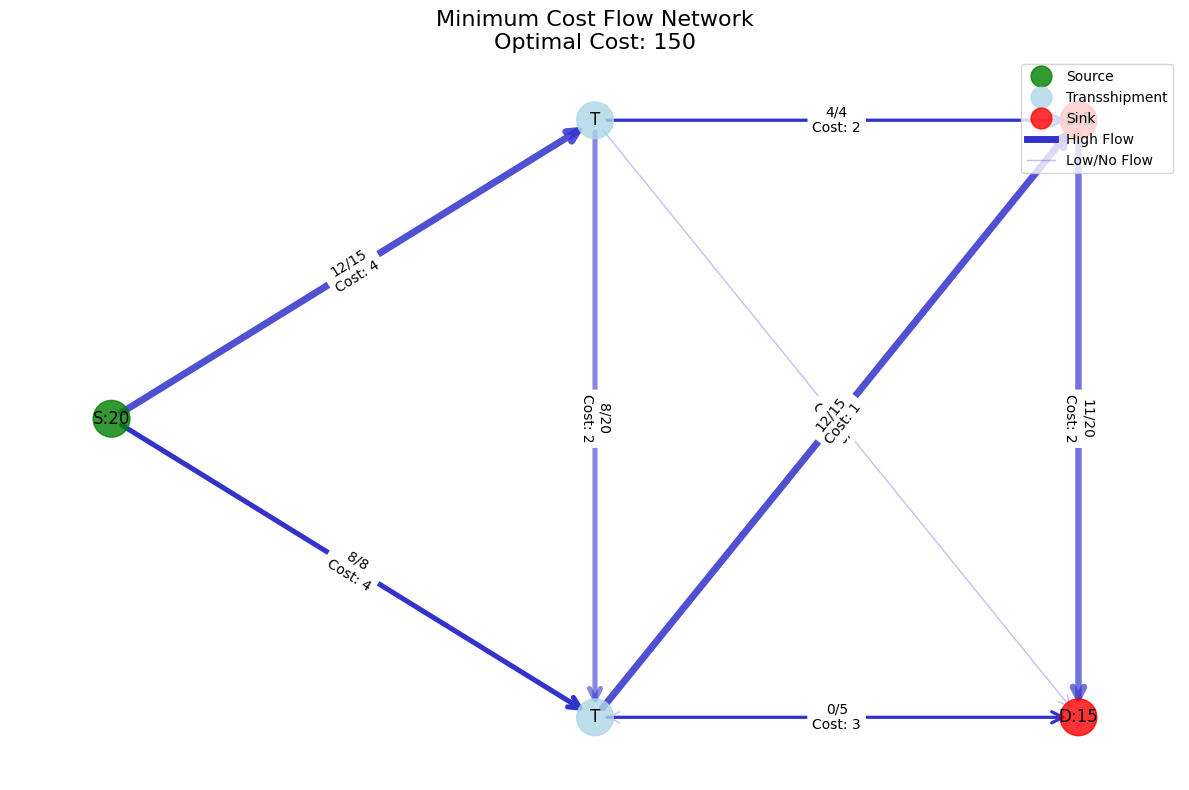

Minimum cost: 150

Arc    Flow / Capacity  Cost
-------------------------------
0 -> 1:  12 /  15        48
0 -> 2:   8 /   8        32
1 -> 2:   8 /  20        16
1 -> 3:   4 /   4        8
1 -> 4:   0 /  10        0
2 -> 3:  12 /  15        12
2 -> 4:   4 /   4        12
3 -> 4:  11 /  20        22
4 -> 2:   0 /   5        0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ortools.graph.python import min_cost_flow

def solve_min_cost_flow():
    """Solve the minimum cost flow problem and return the results"""
    # Instantiate a SimpleMinCostFlow solver
    smcf = min_cost_flow.SimpleMinCostFlow()

    # Define network structure
    start_nodes = np.array([0, 0, 1, 1, 1, 2, 2, 3, 4])
    end_nodes = np.array([1, 2, 2, 3, 4, 3, 4, 4, 2])
    capacities = np.array([15, 8, 20, 4, 10, 15, 4, 20, 5])
    unit_costs = np.array([4, 4, 2, 2, 6, 1, 3, 2, 3])
    supplies = [20, 0, 0, -5, -15]

    # Add arcs, capacities and costs
    all_arcs = smcf.add_arcs_with_capacity_and_unit_cost(
        start_nodes, end_nodes, capacities, unit_costs
    )

    # Add supply for each node
    smcf.set_nodes_supplies(np.arange(0, len(supplies)), supplies)

    # Solve the problem
    status = smcf.solve()

    if status != smcf.OPTIMAL:
        print(f"Error: Could not find optimal solution. Status: {status}")
        return None

    # Get the flow values
    solution_flows = smcf.flows(all_arcs)

    # Create a dictionary of results
    results = {
        'start_nodes': start_nodes,
        'end_nodes': end_nodes,
        'capacities': capacities,
        'unit_costs': unit_costs,
        'supplies': supplies,
        'flows': solution_flows,
        'optimal_cost': smcf.optimal_cost()
    }

    return results

def plot_min_cost_flow_network_with_solution(results):
    """Plot the network with the optimal flow solution"""
    # Extract data from results
    start_nodes = results['start_nodes']
    end_nodes = results['end_nodes']
    capacities = results['capacities']
    unit_costs = results['unit_costs']
    supplies = results['supplies']
    flows = results['flows']
    optimal_cost = results['optimal_cost']

    # Create a directed graph
    G = nx.DiGraph()

    # Define node positions for a clear layout
    pos = {
        0: (0, 2),    # Source
        1: (2, 3),    # Transshipment
        2: (2, 1),    # Transshipment
        3: (4, 3),    # Sink
        4: (4, 1)     # Sink
    }

    # Add nodes
    for i in range(len(supplies)):
        G.add_node(i)

    # Prepare node labels showing supply/demand
    node_labels = {}
    for i, supply in enumerate(supplies):
        if supply > 0:
            node_labels[i] = f"S:{supply}"
        elif supply < 0:
            node_labels[i] = f"D:{-supply}"
        else:
            node_labels[i] = "T"

    # Add edges with flow, capacity and cost information
    for i in range(len(start_nodes)):
        G.add_edge(
            start_nodes[i],
            end_nodes[i],
            flow=int(flows[i]),
            capacity=capacities[i],
            cost=unit_costs[i]
        )

    # Create edge colors based on flow/capacity ratio
    edge_colors = []
    for u, v, data in G.edges(data=True):
        ratio = data['flow'] / data['capacity'] if data['capacity'] > 0 else 0
        # Color from light to dark blue based on flow utilization
        edge_colors.append((0.2, 0.2, 0.8, 0.3 + 0.7 * ratio))

    # Adjust edge widths based on flow
    edge_widths = [1 + 4 * (data['flow'] / max(flows)) for _, _, data in G.edges(data=True)]

    # Create edge labels showing flow/capacity and cost
    edge_labels = {}
    for i in range(len(start_nodes)):
        s, e = start_nodes[i], end_nodes[i]
        edge_labels[(s, e)] = f"{int(flows[i])}/{capacities[i]}\nCost: {unit_costs[i]}"

    # Plot the graph
    plt.figure(figsize=(12, 8))

    # Draw the nodes with different colors for source, transshipment, and sink nodes
    node_colors = ['green' if s > 0 else 'red' if s < 0 else 'lightblue' for s in supplies]
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, alpha=0.8)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, arrowstyle='->', arrowsize=20)

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

    # Add title and info about total cost
    plt.title(f"Minimum Cost Flow Network\nOptimal Cost: {optimal_cost}", fontsize=16)

    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', marker='o', linestyle='', markersize=15, alpha=0.8, label='Source'),
        plt.Line2D([0], [0], color='lightblue', marker='o', linestyle='', markersize=15, alpha=0.8, label='Transshipment'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=15, alpha=0.8, label='Sink'),
        plt.Line2D([0], [0], color=(0.2, 0.2, 0.8, 1.0), linewidth=5, label='High Flow'),
        plt.Line2D([0], [0], color=(0.2, 0.2, 0.8, 0.3), linewidth=1, label='Low/No Flow')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.axis('off')
    plt.tight_layout()

    # Save or show the plot
    plt.savefig("min_cost_flow_network_with_solution.png", dpi=300)
    plt.show()

    # Print solution details
    print(f"Minimum cost: {optimal_cost}")
    print("\nArc    Flow / Capacity  Cost")
    print("-------------------------------")
    for i in range(len(start_nodes)):
        s, e = start_nodes[i], end_nodes[i]
        flow = flows[i]
        capacity = capacities[i]
        cost = unit_costs[i]
        total_cost = flow * cost
        print(f"{s} -> {e}:  {int(flow):2} / {int(capacity):3}        {total_cost}")

if __name__ == "__main__":
    # Solve the problem
    results = solve_min_cost_flow()

    if results:
        # Plot the network with solution
        plot_min_cost_flow_network_with_solution(results)

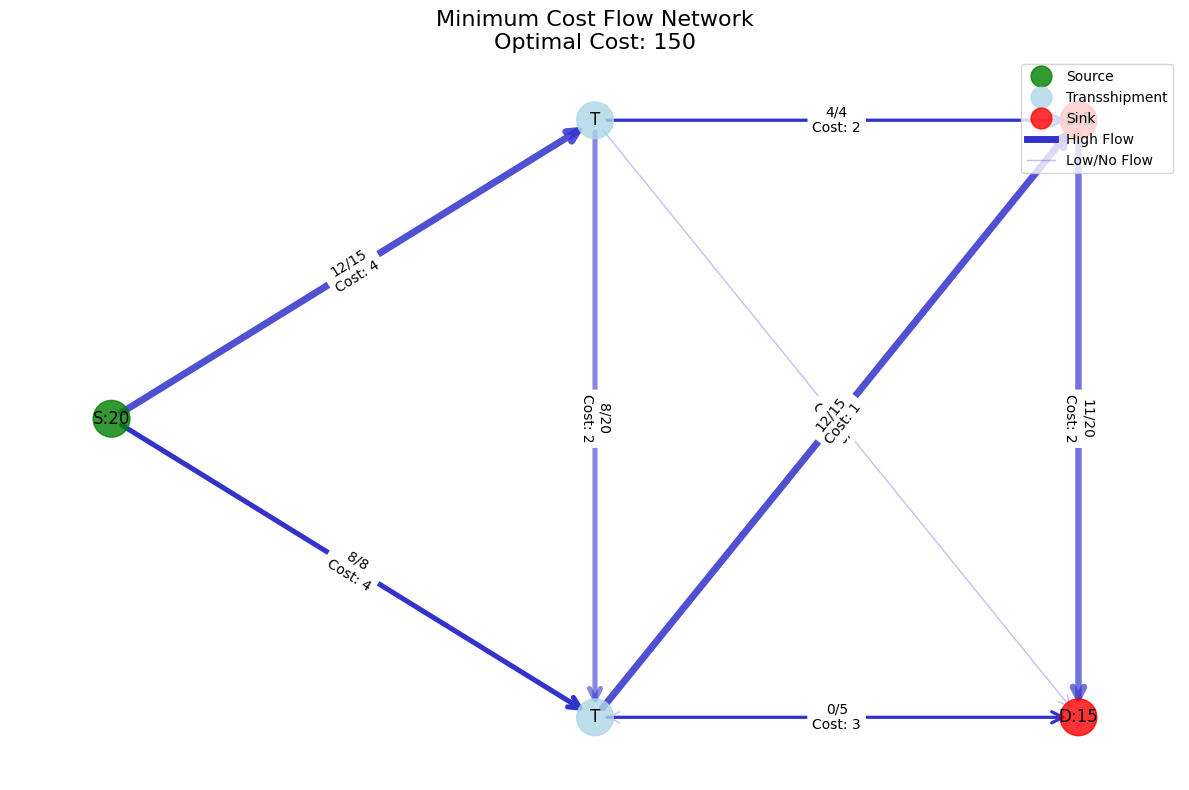

Minimum cost: 150

Arc    Flow / Capacity  Cost
-------------------------------
0 -> 1:  12 /  15        48
0 -> 2:   8 /   8        32
1 -> 2:   8 /  20        16
1 -> 3:   4 /   4        8
1 -> 4:   0 /  10        0
2 -> 3:  12 /  15        12
2 -> 4:   4 /   4        12
3 -> 4:  11 /  20        22
4 -> 2:   0 /   5        0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from ortools.graph.python import min_cost_flow

def solve_min_cost_flow():
    """Solve the minimum cost flow problem and return the results"""
    # Instantiate a SimpleMinCostFlow solver
    smcf = min_cost_flow.SimpleMinCostFlow()

    # Define network structure
    start_nodes = np.array([0, 0, 1, 1, 1, 2, 2, 3, 4])
    end_nodes = np.array([1, 2, 2, 3, 4, 3, 4, 4, 2])
    capacities = np.array([15, 8, 20, 4, 10, 15, 4, 20, 5])
    unit_costs = np.array([4, 4, 2, 2, 6, 1, 3, 2, 3])
    supplies = [20, 0, 0, -5, -15]

    # Add arcs, capacities and costs
    all_arcs = smcf.add_arcs_with_capacity_and_unit_cost(
        start_nodes, end_nodes, capacities, unit_costs
    )

    # Add supply for each node
    smcf.set_nodes_supplies(np.arange(0, len(supplies)), supplies)

    # Solve the problem
    status = smcf.solve()

    if status != smcf.OPTIMAL:
        print(f"Error: Could not find optimal solution. Status: {status}")
        return None

    # Get the flow values
    solution_flows = smcf.flows(all_arcs)

    # Create a dictionary of results
    results = {
        'start_nodes': start_nodes,
        'end_nodes': end_nodes,
        'capacities': capacities,
        'unit_costs': unit_costs,
        'supplies': supplies,
        'flows': solution_flows,
        'optimal_cost': smcf.optimal_cost()
    }

    return results

def plot_min_cost_flow_network_with_solution(results):
    """Plot the network with the optimal flow solution"""
    # Extract data from results
    start_nodes = results['start_nodes']
    end_nodes = results['end_nodes']
    capacities = results['capacities']
    unit_costs = results['unit_costs']
    supplies = results['supplies']
    flows = results['flows']
    optimal_cost = results['optimal_cost']

    # Create a directed graph
    G = nx.DiGraph()

    # Define node positions for a clear layout
    pos = {
        0: (0, 2),    # Source
        1: (2, 3),    # Transshipment
        2: (2, 1),    # Transshipment
        3: (4, 3),    # Sink
        4: (4, 1)     # Sink
    }

    # Add nodes
    for i in range(len(supplies)):
        G.add_node(i)

    # Prepare node labels showing supply/demand
    node_labels = {}
    for i, supply in enumerate(supplies):
        if supply > 0:
            node_labels[i] = f"S:{supply}"
        elif supply < 0:
            node_labels[i] = f"D:{-supply}"
        else:
            node_labels[i] = "T"

    # Add edges with flow, capacity and cost information
    for i in range(len(start_nodes)):
        G.add_edge(
            start_nodes[i],
            end_nodes[i],
            flow=int(flows[i]),
            capacity=capacities[i],
            cost=unit_costs[i]
        )

    # Create edge colors based on flow/capacity ratio
    edge_colors = []
    for u, v, data in G.edges(data=True):
        ratio = data['flow'] / data['capacity'] if data['capacity'] > 0 else 0
        # Color from light to dark blue based on flow utilization
        edge_colors.append((0.2, 0.2, 0.8, 0.3 + 0.7 * ratio))

    # Adjust edge widths based on flow
    edge_widths = [1 + 4 * (data['flow'] / max(flows)) for _, _, data in G.edges(data=True)]

    # Create edge labels showing flow/capacity and cost
    edge_labels = {}
    for i in range(len(start_nodes)):
        s, e = start_nodes[i], end_nodes[i]
        edge_labels[(s, e)] = f"{int(flows[i])}/{capacities[i]}\nCost: {unit_costs[i]}"

    # Plot the graph
    plt.figure(figsize=(12, 8))

    # Draw the nodes with different colors for source, transshipment, and sink nodes
    node_colors = ['green' if s > 0 else 'red' if s < 0 else 'lightblue' for s in supplies]
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, alpha=0.8)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, arrowstyle='->', arrowsize=20)

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

    # Add title and info about total cost
    plt.title(f"Minimum Cost Flow Network\nOptimal Cost: {optimal_cost}", fontsize=16)

    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', marker='o', linestyle='', markersize=15, alpha=0.8, label='Source'),
        plt.Line2D([0], [0], color='lightblue', marker='o', linestyle='', markersize=15, alpha=0.8, label='Transshipment'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=15, alpha=0.8, label='Sink'),
        plt.Line2D([0], [0], color=(0.2, 0.2, 0.8, 1.0), linewidth=5, label='High Flow'),
        plt.Line2D([0], [0], color=(0.2, 0.2, 0.8, 0.3), linewidth=1, label='Low/No Flow')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.axis('off')
    plt.tight_layout()

    # Save or show the plot
    plt.savefig("min_cost_flow_network_with_solution.png", dpi=300)
    plt.show()

    # Print solution details
    print(f"Minimum cost: {optimal_cost}")
    print("\nArc    Flow / Capacity  Cost")
    print("-------------------------------")
    for i in range(len(start_nodes)):
        s, e = start_nodes[i], end_nodes[i]
        flow = flows[i]
        capacity = capacities[i]
        cost = unit_costs[i]
        total_cost = flow * cost
        print(f"{s} -> {e}:  {int(flow):2} / {int(capacity):3}        {total_cost}")

if __name__ == "__main__":
    # Solve the problem
    results = solve_min_cost_flow()

    if results:
        # Plot the network with solution
        plot_min_cost_flow_network_with_solution(results)

Restricted license - for non-production use only - expires 2026-11-23


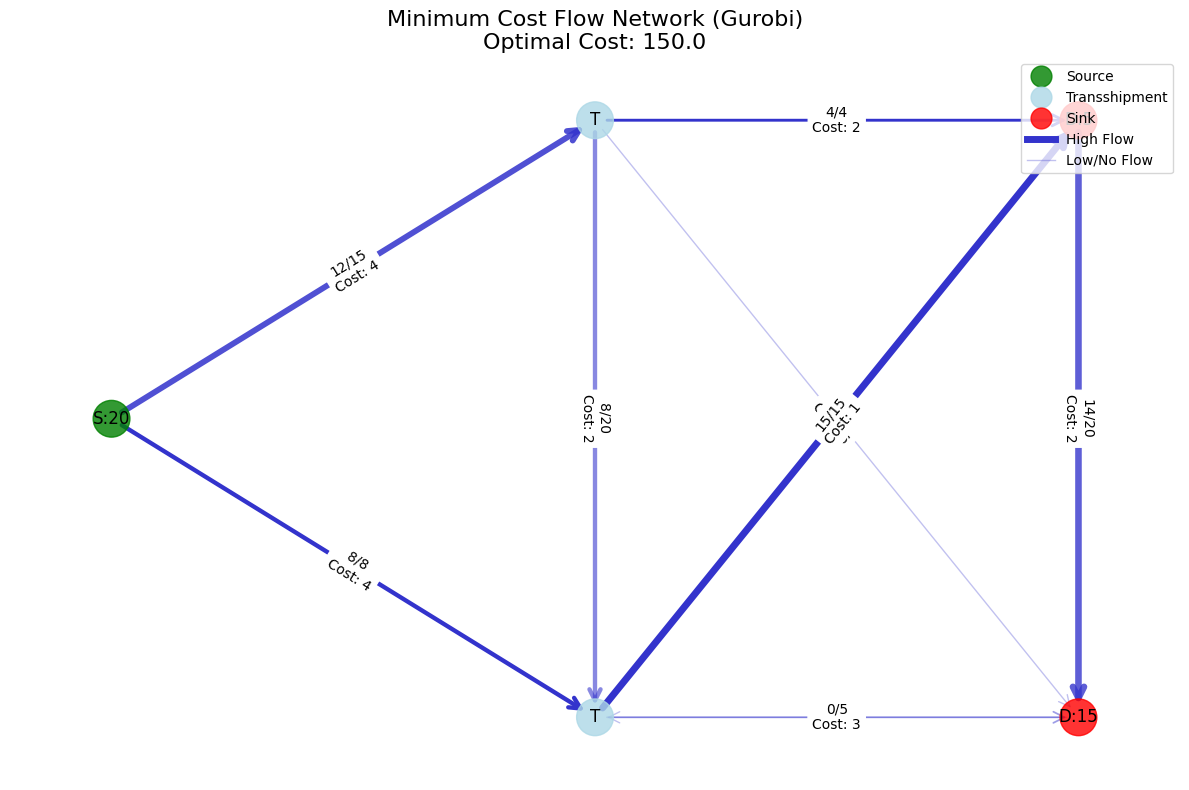

Minimum cost: 150.0

Arc    Flow / Capacity  Cost
-------------------------------
0 -> 1:  12 /  15        48.0
0 -> 2:   8 /   8        32.0
1 -> 2:   8 /  20        16.0
1 -> 3:   4 /   4        8.0
1 -> 4:   0 /  10        0.0
2 -> 3:  15 /  15        15.0
2 -> 4:   1 /   4        3.0
3 -> 4:  14 /  20        28.0
4 -> 2:   0 /   5        0.0


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

def solve_min_cost_flow_gurobi():
    """Solve the minimum cost flow problem using Gurobi"""

    # Define the network structure
    start_nodes = np.array([0, 0, 1, 1, 1, 2, 2, 3, 4])
    end_nodes = np.array([1, 2, 2, 3, 4, 3, 4, 4, 2])
    capacities = np.array([15, 8, 20, 4, 10, 15, 4, 20, 5])
    unit_costs = np.array([4, 4, 2, 2, 6, 1, 3, 2, 3])
    supplies = [20, 0, 0, -5, -15]

    # Create a list of arcs
    arcs = [(start_nodes[i], end_nodes[i]) for i in range(len(start_nodes))]

    # Create a dictionary with arc capacities
    arc_capacities = {(start_nodes[i], end_nodes[i]): capacities[i] for i in range(len(start_nodes))}

    # Create a dictionary with arc costs
    arc_costs = {(start_nodes[i], end_nodes[i]): unit_costs[i] for i in range(len(start_nodes))}

    try:
        # Create a new model
        model = gp.Model("MinCostFlow")

        # Suppress output
        model.setParam('OutputFlag', 0)

        # Create flow variables for each arc
        flow_vars = {}
        for arc in arcs:
            flow_vars[arc] = model.addVar(
                lb=0,
                ub=arc_capacities[arc],
                obj=arc_costs[arc],
                vtype=GRB.CONTINUOUS,
                name=f"flow_{arc[0]}_{arc[1]}"
            )

        # Update model to include the new variables
        model.update()

        # Add flow conservation constraints for each node
        nodes = set(start_nodes) | set(end_nodes)
        for node in nodes:
            # Outgoing arcs from this node
            outgoing = [arc for arc in arcs if arc[0] == node]
            # Incoming arcs to this node
            incoming = [arc for arc in arcs if arc[1] == node]

            # Flow conservation: outgoing - incoming = supply
            # (negative supply means demand)
            supply = supplies[node] if node < len(supplies) else 0
            model.addConstr(
                gp.quicksum(flow_vars[arc] for arc in outgoing) -
                gp.quicksum(flow_vars[arc] for arc in incoming) == supply,
                name=f"Flow_Conservation_Node_{node}"
            )

        # Optimize the model
        model.optimize()

        # Check if the solution is optimal
        if model.status != GRB.OPTIMAL:
            print(f"Error: Could not find optimal solution. Status: {model.status}")
            return None

        # Extract the flow values
        flows = np.zeros(len(arcs))
        for i, arc in enumerate(arcs):
            flows[i] = flow_vars[arc].X

        # Calculate the optimal cost
        optimal_cost = model.objVal

        # Create a dictionary of results
        results = {
            'start_nodes': start_nodes,
            'end_nodes': end_nodes,
            'capacities': capacities,
            'unit_costs': unit_costs,
            'supplies': supplies,
            'flows': flows,
            'optimal_cost': optimal_cost
        }

        return results

    except gp.GurobiError as e:
        print(f"Gurobi error: {e}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

def plot_min_cost_flow_network_with_solution(results):
    """Plot the network with the optimal flow solution"""
    # Extract data from results
    start_nodes = results['start_nodes']
    end_nodes = results['end_nodes']
    capacities = results['capacities']
    unit_costs = results['unit_costs']
    supplies = results['supplies']
    flows = results['flows']
    optimal_cost = results['optimal_cost']

    # Create a directed graph
    G = nx.DiGraph()

    # Define node positions for a clear layout
    pos = {
        0: (0, 2),    # Source
        1: (2, 3),    # Transshipment
        2: (2, 1),    # Transshipment
        3: (4, 3),    # Sink
        4: (4, 1)     # Sink
    }

    # Add nodes
    for i in range(len(supplies)):
        G.add_node(i)

    # Prepare node labels showing supply/demand
    node_labels = {}
    for i, supply in enumerate(supplies):
        if supply > 0:
            node_labels[i] = f"S:{supply}"
        elif supply < 0:
            node_labels[i] = f"D:{-supply}"
        else:
            node_labels[i] = "T"

    # Add edges with flow, capacity and cost information
    for i in range(len(start_nodes)):
        G.add_edge(
            start_nodes[i],
            end_nodes[i],
            flow=int(flows[i]),
            capacity=capacities[i],
            cost=unit_costs[i]
        )

    # Create edge colors based on flow/capacity ratio
    edge_colors = []
    for u, v, data in G.edges(data=True):
        ratio = data['flow'] / data['capacity'] if data['capacity'] > 0 else 0
        # Color from light to dark blue based on flow utilization
        edge_colors.append((0.2, 0.2, 0.8, 0.3 + 0.7 * ratio))

    # Adjust edge widths based on flow
    edge_widths = [1 + 4 * (data['flow'] / max(flows)) if max(flows) > 0 else 1
                  for _, _, data in G.edges(data=True)]

    # Create edge labels showing flow/capacity and cost
    edge_labels = {}
    for i in range(len(start_nodes)):
        s, e = start_nodes[i], end_nodes[i]
        edge_labels[(s, e)] = f"{int(flows[i])}/{capacities[i]}\nCost: {unit_costs[i]}"

    # Plot the graph
    plt.figure(figsize=(12, 8))

    # Draw the nodes with different colors for source, transshipment, and sink nodes
    node_colors = ['green' if s > 0 else 'red' if s < 0 else 'lightblue' for s in supplies]
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors, alpha=0.8)

    # Draw the edges
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, arrowstyle='->', arrowsize=20)

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)

    # Add title and info about total cost
    plt.title(f"Minimum Cost Flow Network (Gurobi)\nOptimal Cost: {optimal_cost}", fontsize=16)

    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', marker='o', linestyle='', markersize=15, alpha=0.8, label='Source'),
        plt.Line2D([0], [0], color='lightblue', marker='o', linestyle='', markersize=15, alpha=0.8, label='Transshipment'),
        plt.Line2D([0], [0], color='red', marker='o', linestyle='', markersize=15, alpha=0.8, label='Sink'),
        plt.Line2D([0], [0], color=(0.2, 0.2, 0.8, 1.0), linewidth=5, label='High Flow'),
        plt.Line2D([0], [0], color=(0.2, 0.2, 0.8, 0.3), linewidth=1, label='Low/No Flow')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.axis('off')
    plt.tight_layout()

    # Save or show the plot
    plt.savefig("min_cost_flow_network_gurobi.png", dpi=300)
    plt.show()

    # Print solution details
    print(f"Minimum cost: {optimal_cost}")
    print("\nArc    Flow / Capacity  Cost")
    print("-------------------------------")
    for i in range(len(start_nodes)):
        s, e = start_nodes[i], end_nodes[i]
        flow = flows[i]
        capacity = capacities[i]
        cost = unit_costs[i]
        total_cost = flow * cost
        print(f"{s} -> {e}:  {int(flow):2} / {int(capacity):3}        {total_cost}")

if __name__ == "__main__":
    # Solve the problem
    results = solve_min_cost_flow_gurobi()

    if results:
        # Plot the network with solution
        plot_min_cost_flow_network_with_solution(results)

## Comparison

Running solver benchmark...
Benchmarking problem size: 100 nodes
  Average times - OR-Tools: 0.0004s, PuLP: 0.0242s, Gurobi: 0.0093s
Benchmarking problem size: 150 nodes
  Average times - OR-Tools: 0.0004s, PuLP: 0.0317s, Gurobi: 0.0151s
Benchmarking problem size: 200 nodes
  Average times - OR-Tools: 0.0004s, PuLP: 0.0421s, Gurobi: 0.0238s
Benchmarking problem size: 250 nodes
  Average times - OR-Tools: 0.0006s, PuLP: 0.0717s, Gurobi: 0.0327s
Benchmarking problem size: 300 nodes
  Average times - OR-Tools: 0.0007s, PuLP: 0.0773s, Gurobi: 0.0461s
Benchmarking problem size: 350 nodes
  Average times - OR-Tools: 0.0006s, PuLP: 0.0906s, Gurobi: 0.0583s
Benchmarking problem size: 400 nodes
  Average times - OR-Tools: 0.0009s, PuLP: 0.1167s, Gurobi: 0.0760s
Benchmarking problem size: 450 nodes
  Average times - OR-Tools: 0.0010s, PuLP: 0.1372s, Gurobi: 0.0992s
Benchmarking problem size: 500 nodes
  Average times - OR-Tools: 0.0005s, PuLP: 0.1679s, Gurobi: 0.1138s
Benchmarking problem size: 

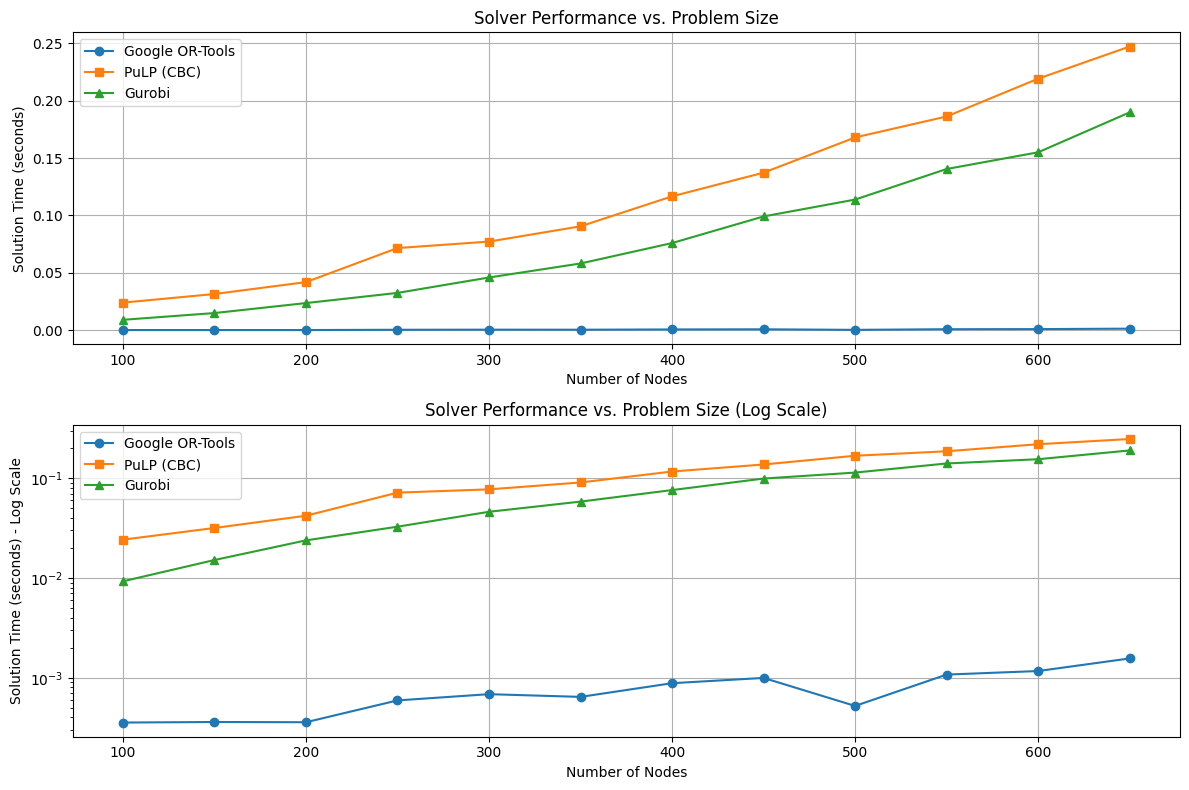


Benchmark Results:
-------------------------------------------
Nodes | Edges | OR-Tools | PuLP | Gurobi
-------------------------------------------
  100 | 298.3 | 0.0004 | 0.0242 | 0.0093
  150 | 447.7 | 0.0004 | 0.0317 | 0.0151
  200 | 595.3 | 0.0004 | 0.0421 | 0.0238
  250 | 746.7 | 0.0006 | 0.0717 | 0.0327
  300 | 897.0 | 0.0007 | 0.0773 | 0.0461
  350 | 1048.0 | 0.0006 | 0.0906 | 0.0583
  400 | 1196.3 | 0.0009 | 0.1167 | 0.0760
  450 | 1347.7 | 0.0010 | 0.1372 | 0.0992
  500 | 1498.0 | 0.0005 | 0.1679 | 0.1138
  550 | 1647.0 | 0.0011 | 0.1861 | 0.1404
  600 | 1797.7 | 0.0012 | 0.2190 | 0.1550
  650 | 1946.7 | 0.0016 | 0.2470 | 0.1897


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import networkx as nx
import random
from ortools.graph.python import min_cost_flow
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, PULP_CBC_CMD

# Try to import Gurobi - this way the benchmark will still run even if Gurobi isn't installed
try:
    import gurobipy as gp
    from gurobipy import GRB
    GUROBI_AVAILABLE = True
except ImportError:
    GUROBI_AVAILABLE = False
    print("Gurobi not available. Will benchmark only OR-Tools and PuLP.")

def generate_random_network(num_nodes):
    """Generate a random minimum cost flow network with specified number of nodes"""
    # Create a random connected directed graph
    G = nx.gnm_random_graph(num_nodes, num_nodes * 2, directed=True)

    # Make sure the graph is connected by adding a directed path if necessary
    if not nx.is_weakly_connected(G):
        nodes = list(G.nodes())
        for i in range(len(nodes) - 1):
            G.add_edge(nodes[i], nodes[i + 1])

    # Get list of edges
    edges = list(G.edges())
    start_nodes = np.array([e[0] for e in edges])
    end_nodes = np.array([e[1] for e in edges])

    # Generate random capacities between 5 and 30
    capacities = np.array([random.randint(5, 30) for _ in range(len(edges))])

    # Generate random costs between 1 and 10
    unit_costs = np.array([random.randint(1, 10) for _ in range(len(edges))])

    # Create supplies: one source, one sink, rest are transshipment
    supplies = [0] * num_nodes
    source_node = 0
    sink_node = num_nodes - 1

    # Set a random supply amount between 10 and 20 units per node
    supply_amount = random.randint(10, 20)
    supplies[source_node] = supply_amount
    supplies[sink_node] = -supply_amount

    return {
        'start_nodes': start_nodes,
        'end_nodes': end_nodes,
        'capacities': capacities,
        'unit_costs': unit_costs,
        'supplies': supplies,
        'num_nodes': num_nodes,
        'num_edges': len(edges)
    }

def solve_with_ortools(network_data):
    """Solve minimum cost flow problem using Google OR-Tools"""
    # Extract network data
    start_nodes = network_data['start_nodes']
    end_nodes = network_data['end_nodes']
    capacities = network_data['capacities']
    unit_costs = network_data['unit_costs']
    supplies = network_data['supplies']

    # Start timer
    start_time = time.time()

    # Instantiate a SimpleMinCostFlow solver
    smcf = min_cost_flow.SimpleMinCostFlow()

    # Add arcs, capacities and costs
    all_arcs = smcf.add_arcs_with_capacity_and_unit_cost(
        start_nodes, end_nodes, capacities, unit_costs
    )

    # Add supply for each node
    smcf.set_nodes_supplies(np.arange(0, len(supplies)), supplies)

    # Solve the problem
    status = smcf.solve()

    # End timer
    end_time = time.time()

    if status != smcf.OPTIMAL:
        return None, None

    # Calculate solution time
    solution_time = end_time - start_time

    # Get the optimal cost
    optimal_cost = smcf.optimal_cost()

    return optimal_cost, solution_time

def solve_with_pulp(network_data):
    """Solve minimum cost flow problem using PuLP"""
    # Extract network data
    start_nodes = network_data['start_nodes']
    end_nodes = network_data['end_nodes']
    capacities = network_data['capacities']
    unit_costs = network_data['unit_costs']
    supplies = network_data['supplies']

    # Create a dictionary of arcs
    arcs = [(start_nodes[i], end_nodes[i]) for i in range(len(start_nodes))]

    # Create a dictionary with arc capacities
    arc_capacities = {(start_nodes[i], end_nodes[i]): capacities[i] for i in range(len(start_nodes))}

    # Create a dictionary with arc costs
    arc_costs = {(start_nodes[i], end_nodes[i]): unit_costs[i] for i in range(len(start_nodes))}

    # Start timer
    start_time = time.time()

    # Create the model
    model = LpProblem("MinCostFlow", LpMinimize)

    # Create flow variables for each arc
    flow_vars = {arc: LpVariable(f"flow_{arc[0]}_{arc[1]}", lowBound=0, upBound=arc_capacities[arc])
                for arc in arcs}

    # Set the objective function: minimize total cost
    model += lpSum(flow_vars[arc] * arc_costs[arc] for arc in arcs), "Total Cost"

    # Add flow conservation constraints for each node
    nodes = set(range(network_data['num_nodes']))
    for node in nodes:
        # Outgoing arcs from this node
        outgoing = [arc for arc in arcs if arc[0] == node]
        # Incoming arcs to this node
        incoming = [arc for arc in arcs if arc[1] == node]

        # Flow conservation: outgoing - incoming = supply
        # (negative supply means demand)
        supply = supplies[node] if node < len(supplies) else 0
        model += (lpSum(flow_vars[arc] for arc in outgoing) -
                 lpSum(flow_vars[arc] for arc in incoming) == supply), f"Flow_Conservation_Node_{node}"

    # Solve the problem
    model.solve(PULP_CBC_CMD(msg=False))

    # End timer
    end_time = time.time()

    # Check if the solution is optimal
    if model.status != 1:
        return None, None

    # Calculate solution time
    solution_time = end_time - start_time

    # Calculate the optimal cost
    optimal_cost = sum(flow_vars[arc].value() * arc_costs[arc] for arc in arcs)

    return optimal_cost, solution_time

def solve_with_gurobi(network_data):
    """Solve minimum cost flow problem using Gurobi"""
    if not GUROBI_AVAILABLE:
        return None, None

    # Extract network data
    start_nodes = network_data['start_nodes']
    end_nodes = network_data['end_nodes']
    capacities = network_data['capacities']
    unit_costs = network_data['unit_costs']
    supplies = network_data['supplies']

    # Create a list of arcs
    arcs = [(start_nodes[i], end_nodes[i]) for i in range(len(start_nodes))]

    # Create a dictionary with arc capacities
    arc_capacities = {(start_nodes[i], end_nodes[i]): capacities[i] for i in range(len(start_nodes))}

    # Create a dictionary with arc costs
    arc_costs = {(start_nodes[i], end_nodes[i]): unit_costs[i] for i in range(len(start_nodes))}

    try:
        # Start timer
        start_time = time.time()

        # Create a new model
        model = gp.Model("MinCostFlow")

        # Suppress output
        model.setParam('OutputFlag', 0)

        # Create flow variables for each arc
        flow_vars = {}
        for arc in arcs:
            flow_vars[arc] = model.addVar(
                lb=0,
                ub=arc_capacities[arc],
                obj=arc_costs[arc],
                vtype=GRB.CONTINUOUS,
                name=f"flow_{arc[0]}_{arc[1]}"
            )

        # Add flow conservation constraints for each node
        nodes = set(range(network_data['num_nodes']))
        for node in nodes:
            # Outgoing arcs from this node
            outgoing = [arc for arc in arcs if arc[0] == node]
            # Incoming arcs to this node
            incoming = [arc for arc in arcs if arc[1] == node]

            # Flow conservation: outgoing - incoming = supply
            # (negative supply means demand)
            supply = supplies[node] if node < len(supplies) else 0
            model.addConstr(
                gp.quicksum(flow_vars[arc] for arc in outgoing) -
                gp.quicksum(flow_vars[arc] for arc in incoming) == supply,
                name=f"Flow_Conservation_Node_{node}"
            )

        # Optimize the model
        model.optimize()

        # End timer
        end_time = time.time()

        # Check if the solution is optimal
        if model.status != GRB.OPTIMAL:
            return None, None

        # Calculate solution time
        solution_time = end_time - start_time

        # Get the optimal cost
        optimal_cost = model.objVal

        return optimal_cost, solution_time

    except Exception as e:
        print(f"Gurobi error: {e}")
        return None, None

def run_benchmark():
    """Run benchmark comparing solvers across different problem sizes"""
    # Define the range of problem sizes to test
    problem_sizes = list(range(100, 1001, 50))  # 10, 20, ..., 100 nodes

    # Number of trials for each size
    num_trials = 3

    # Initialize results dictionaries
    ortools_times = []
    pulp_times = []
    gurobi_times = []

    # Initialize problem size statistics
    size_stats = []

    # Run benchmarks
    for size in problem_sizes:
        print(f"Benchmarking problem size: {size} nodes")

        ortools_time_sum = 0
        pulp_time_sum = 0
        gurobi_time_sum = 0
        edge_count_sum = 0

        successful_trials = 0

        for trial in range(num_trials):
            # Generate a random network
            network = generate_random_network(size)
            edge_count_sum += network['num_edges']

            # Solve with OR-Tools
            ort_cost, ort_time = solve_with_ortools(network)

            # Solve with PuLP
            pulp_cost, pulp_time = solve_with_pulp(network)

            # Solve with Gurobi if available
            if GUROBI_AVAILABLE:
                gurobi_cost, gurobi_time = solve_with_gurobi(network)
            else:
                gurobi_cost, gurobi_time = None, None

            # Check if all solvers found a solution
            if ort_cost is not None and pulp_cost is not None and (not GUROBI_AVAILABLE or gurobi_cost is not None):
                ortools_time_sum += ort_time
                pulp_time_sum += pulp_time
                if GUROBI_AVAILABLE:
                    gurobi_time_sum += gurobi_time
                successful_trials += 1

        # Calculate average times if we have successful trials
        if successful_trials > 0:
            ortools_times.append(ortools_time_sum / successful_trials)
            pulp_times.append(pulp_time_sum / successful_trials)
            if GUROBI_AVAILABLE:
                gurobi_times.append(gurobi_time_sum / successful_trials)
            avg_edges = edge_count_sum / num_trials
            size_stats.append((size, avg_edges))
            print(f"  Average times - OR-Tools: {ortools_times[-1]:.4f}s, PuLP: {pulp_times[-1]:.4f}s", end="")
            if GUROBI_AVAILABLE:
                print(f", Gurobi: {gurobi_times[-1]:.4f}s")
            else:
                print()
        else:
            print("  No successful trials for this size")

    return {
        'problem_sizes': [s[0] for s in size_stats],
        'edge_counts': [s[1] for s in size_stats],
        'ortools_times': ortools_times,
        'pulp_times': pulp_times,
        'gurobi_times': gurobi_times if GUROBI_AVAILABLE else None
    }

def plot_benchmark_results(results):
    """Plot the benchmark results"""
    problem_sizes = results['problem_sizes']
    ortools_times = results['ortools_times']
    pulp_times = results['pulp_times']
    gurobi_times = results['gurobi_times']

    plt.figure(figsize=(12, 8))

    # Plot solution time vs. problem size
    plt.subplot(2, 1, 1)
    plt.plot(problem_sizes, ortools_times, 'o-', label='Google OR-Tools')
    plt.plot(problem_sizes, pulp_times, 's-', label='PuLP (CBC)')
    if gurobi_times:
        plt.plot(problem_sizes, gurobi_times, '^-', label='Gurobi')

    plt.xlabel('Number of Nodes')
    plt.ylabel('Solution Time (seconds)')
    plt.title('Solver Performance vs. Problem Size')
    plt.grid(True)
    plt.legend()

    # Plot solution time on a log scale
    plt.subplot(2, 1, 2)
    plt.semilogy(problem_sizes, ortools_times, 'o-', label='Google OR-Tools')
    plt.semilogy(problem_sizes, pulp_times, 's-', label='PuLP (CBC)')
    if gurobi_times:
        plt.semilogy(problem_sizes, gurobi_times, '^-', label='Gurobi')

    plt.xlabel('Number of Nodes')
    plt.ylabel('Solution Time (seconds) - Log Scale')
    plt.title('Solver Performance vs. Problem Size (Log Scale)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.savefig('solver_benchmark_results.png', dpi=300)
    plt.show()

    # Create a table of results
    print("\nBenchmark Results:")
    print("-------------------------------------------")
    print("Nodes | Edges | OR-Tools | PuLP | Gurobi")
    print("-------------------------------------------")

    for i in range(len(problem_sizes)):
        gurobi_str = f"{gurobi_times[i]:.4f}" if gurobi_times else "N/A"
        print(f"{problem_sizes[i]:5} | {results['edge_counts'][i]:5.1f} | {ortools_times[i]:.4f} | {pulp_times[i]:.4f} | {gurobi_str}")

if __name__ == "__main__":
    print("Running solver benchmark...")
    benchmark_results = run_benchmark()
    plot_benchmark_results(benchmark_results)

Status: Optimal

Optimal Solution:
Total Cost: 111.0

Flows on each arc:
Flow from S to A: 5.0
Flow from S to B: 10.0
Flow from A to C: 5.0
Flow from B to C: 5.0
Flow from B to D: 5.0
Flow from C to D: 7.0
Flow from C to T: 3.0
Flow from D to T: 12.0


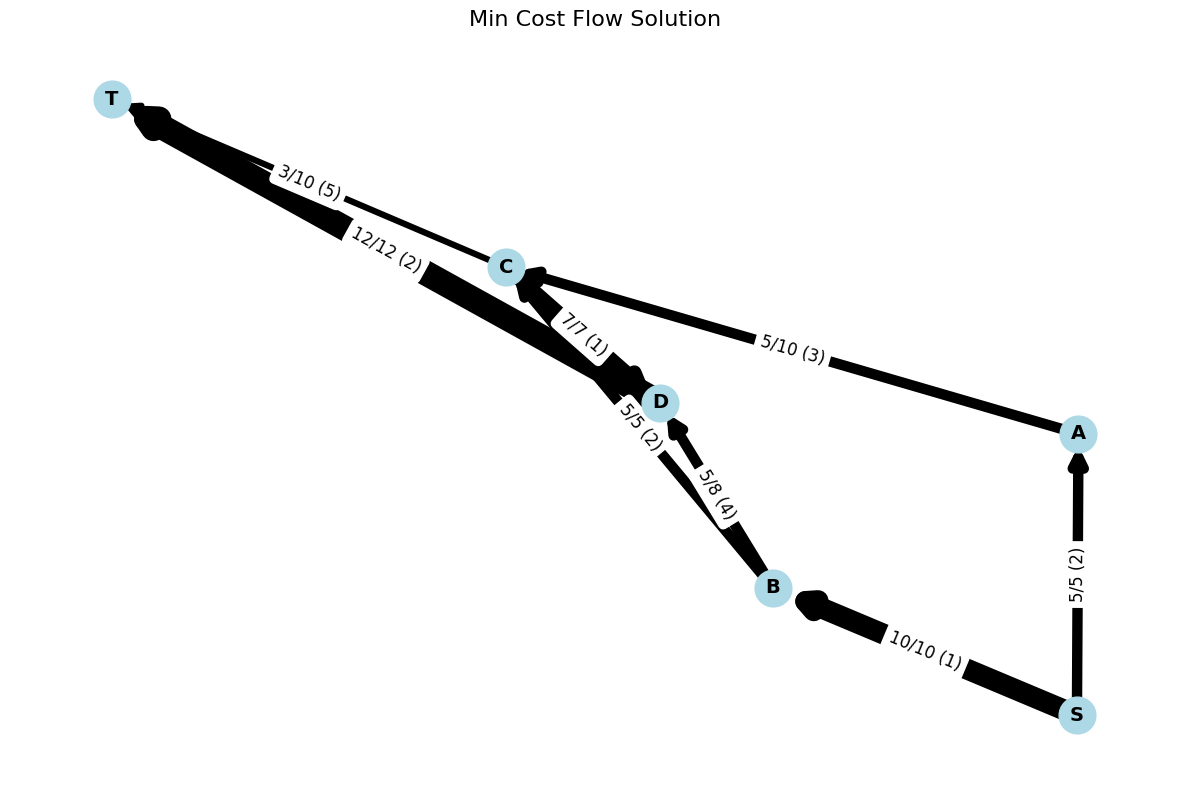

In [ ]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt

# Create a minimum cost flow problem
def solve_min_cost_flow():
    # Create the model
    model = pulp.LpProblem("Min_Cost_Flow_Problem", pulp.LpMinimize)

    # Define the nodes and arcs in our network
    nodes = ['S', 'A', 'B', 'C', 'D', 'T']

    # Define the arcs (from_node, to_node) with their capacities and costs
    arcs = {
        ('S', 'A'): {'capacity': 5, 'cost': 2},
        ('S', 'B'): {'capacity': 10, 'cost': 1},
        ('A', 'B'): {'capacity': 5, 'cost': 1},
        ('A', 'C'): {'capacity': 10, 'cost': 3},
        ('B', 'C'): {'capacity': 5, 'cost': 2},
        ('B', 'D'): {'capacity': 8, 'cost': 4},
        ('C', 'D'): {'capacity': 7, 'cost': 1},
        ('C', 'T'): {'capacity': 10, 'cost': 5},
        ('D', 'T'): {'capacity': 12, 'cost': 2}
    }

    # Supply/demand for each node
    # Positive means supply, negative means demand
    supply_demand = {
        'S': 15,  # Source with 15 units of supply
        'A': 0,   # Transshipment node (no supply or demand)
        'B': 0,   # Transshipment node
        'C': 0,   # Transshipment node
        'D': 0,   # Transshipment node
        'T': -15  # Sink with demand of 15 units
    }

    # Define the flow variables (x_i_j = flow from node i to node j)
    flow_vars = {}
    for (i, j), arc_data in arcs.items():
        flow_vars[(i, j)] = pulp.LpVariable(f"flow_{i}_{j}",
                                           lowBound=0,
                                           upBound=arc_data['capacity'],
                                           cat=pulp.LpInteger)

    # Objective function: minimize the total cost
    model += pulp.lpSum(flow_vars[(i, j)] * arc_data['cost'] for (i, j), arc_data in arcs.items())

    # Flow conservation constraints
    for node in nodes:
        # Outgoing flow - incoming flow = supply/demand
        outgoing = pulp.lpSum(flow_vars[(i, j)] for (i, j) in arcs if i == node)
        incoming = pulp.lpSum(flow_vars[(i, j)] for (i, j) in arcs if j == node)
        model += outgoing - incoming == supply_demand[node], f"flow_conservation_{node}"

    # Solve the model
    model.solve(pulp.PULP_CBC_CMD(msg=False))

    print(f"Status: {pulp.LpStatus[model.status]}")

    # Check if the solution is optimal
    if model.status == pulp.LpStatusOptimal:
        print("\nOptimal Solution:")
        print(f"Total Cost: {pulp.value(model.objective)}")

        # Print the flows on each arc
        print("\nFlows on each arc:")
        for (i, j) in arcs:
            if pulp.value(flow_vars[(i, j)]) > 0:
                print(f"Flow from {i} to {j}: {pulp.value(flow_vars[(i, j)])}")

        # Return the solution for visualization
        flow_solution = {(i, j): pulp.value(flow_vars[(i, j)]) for (i, j) in arcs}
        return flow_solution

    return None

# Visualize the network and solution
def visualize_solution(arcs, flow_solution):
    G = nx.DiGraph()

    # Add all arcs
    for (i, j), arc_data in arcs.items():
        flow = flow_solution.get((i, j), 0)
        if flow > 0:
            # Format the label as "flow/capacity (cost)"
            label = f"{int(flow)}/{arc_data['capacity']} ({arc_data['cost']})"
            G.add_edge(i, j, weight=flow, capacity=arc_data['capacity'],
                      cost=arc_data['cost'], label=label)

    # Position nodes using a layout algorithm
    pos = nx.spring_layout(G, seed=42)

    # Draw the graph
    plt.figure(figsize=(12, 8))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=700)

    # Draw edges with different widths based on flow
    edges = G.edges()
    weights = [G[u][v]['weight'] * 1.5 for u, v in edges]
    nx.draw_networkx_edges(G, pos, width=weights, arrows=True, arrowsize=20)

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight="bold")

    # Draw edge labels
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=12)

    plt.title("Min Cost Flow Solution", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Run the model and display results
if __name__ == "__main__":
    # Create the arcs dictionary for the visualization
    arcs = {
        ('S', 'A'): {'capacity': 5, 'cost': 2},
        ('S', 'B'): {'capacity': 10, 'cost': 1},
        ('A', 'B'): {'capacity': 5, 'cost': 1},
        ('A', 'C'): {'capacity': 10, 'cost': 3},
        ('B', 'C'): {'capacity': 5, 'cost': 2},
        ('B', 'D'): {'capacity': 8, 'cost': 4},
        ('C', 'D'): {'capacity': 7, 'cost': 1},
        ('C', 'T'): {'capacity': 10, 'cost': 5},
        ('D', 'T'): {'capacity': 12, 'cost': 2}
    }

    # Solve the problem
    flow_solution = solve_min_cost_flow()

    # Visualize the solution
    if flow_solution:
        visualize_solution(arcs, flow_solution)

Status: Optimal

Optimal Solution:
Total Cost: 111.0

Flows on each arc:
Flow from S to A: 5.0
Flow from S to B: 10.0
Flow from A to C: 5.0
Flow from B to C: 5.0
Flow from B to D: 5.0
Flow from C to D: 7.0
Flow from C to T: 3.0
Flow from D to T: 12.0


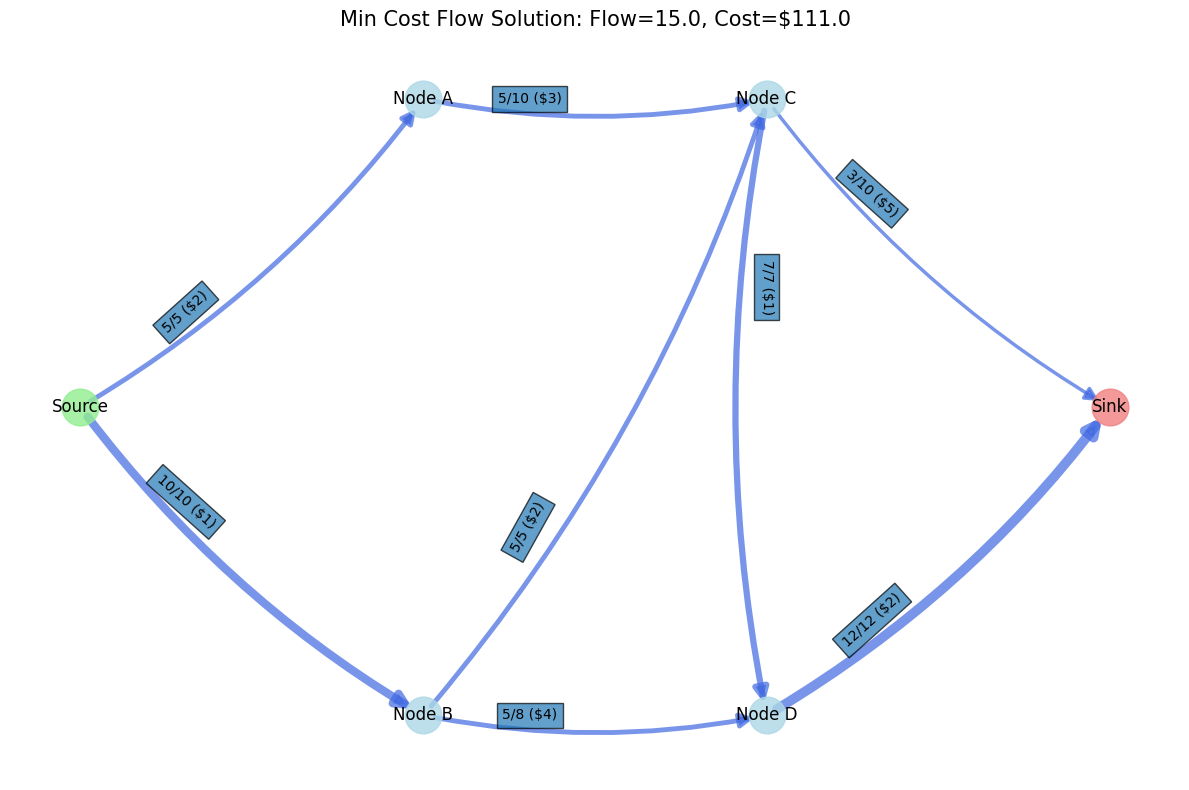

In [ ]:
import pulp
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

def solve_min_cost_flow():
    """Solve a minimum cost flow problem using PuLP."""
    # Create the model
    model = pulp.LpProblem("Min_Cost_Flow_Problem", pulp.LpMinimize)

    # Define the nodes
    nodes = ['S', 'A', 'B', 'C', 'D', 'T']

    # Define the arcs (from_node, to_node) with their capacities and costs
    arcs = {
        ('S', 'A'): {'capacity': 5, 'cost': 2},
        ('S', 'B'): {'capacity': 10, 'cost': 1},
        ('A', 'B'): {'capacity': 5, 'cost': 1},
        ('A', 'C'): {'capacity': 10, 'cost': 3},
        ('B', 'C'): {'capacity': 5, 'cost': 2},
        ('B', 'D'): {'capacity': 8, 'cost': 4},
        ('C', 'D'): {'capacity': 7, 'cost': 1},
        ('C', 'T'): {'capacity': 10, 'cost': 5},
        ('D', 'T'): {'capacity': 12, 'cost': 2}
    }

    # Supply/demand for each node
    # Positive means supply, negative means demand
    supply_demand = {
        'S': 15,  # Source with 15 units of supply
        'A': 0,   # Transshipment node (no supply or demand)
        'B': 0,   # Transshipment node
        'C': 0,   # Transshipment node
        'D': 0,   # Transshipment node
        'T': -15  # Sink with demand of 15 units
    }

    # Define the flow variables (x_i_j = flow from node i to node j)
    flow_vars = {}
    for (i, j), arc_data in arcs.items():
        flow_vars[(i, j)] = pulp.LpVariable(f"flow_{i}_{j}",
                                           lowBound=0,
                                           upBound=arc_data['capacity'],
                                           cat=pulp.LpInteger)

    # Objective function: minimize the total cost
    model += pulp.lpSum(flow_vars[(i, j)] * arc_data['cost'] for (i, j), arc_data in arcs.items())

    # Flow conservation constraints
    for node in nodes:
        # Outgoing flow - incoming flow = supply/demand
        outgoing = pulp.lpSum(flow_vars[(i, j)] for (i, j) in arcs if i == node)
        incoming = pulp.lpSum(flow_vars[(i, j)] for (i, j) in arcs if j == node)
        model += outgoing - incoming == supply_demand[node], f"flow_conservation_{node}"

    # Solve the model
    model.solve(pulp.PULP_CBC_CMD(msg=False))

    print(f"Status: {pulp.LpStatus[model.status]}")

    # Check if the solution is optimal
    if model.status == pulp.LpStatusOptimal:
        print("\nOptimal Solution:")
        print(f"Total Cost: {pulp.value(model.objective)}")

        # Print the flows on each arc
        print("\nFlows on each arc:")
        flow_solution = {}
        for (i, j) in arcs:
            flow_value = pulp.value(flow_vars[(i, j)])
            flow_solution[(i, j)] = flow_value
            if flow_value > 0:
                print(f"Flow from {i} to {j}: {flow_value}")

        # Return the solution, arcs, and nodes for visualization
        return flow_solution, arcs, nodes

    return None, None, None

def visualize_min_cost_flow(flows, arcs):
    """Visualize the minimum cost flow solution."""

    # Extract data for visualization
    start_nodes = []
    end_nodes = []
    capacities = []
    costs = []

    for (i, j), arc_data in arcs.items():
        start_nodes.append(i)
        end_nodes.append(j)
        capacities.append(arc_data['capacity'])
        costs.append(arc_data['cost'])

    # Convert to numpy arrays
    start_nodes = np.array(start_nodes)
    end_nodes = np.array(end_nodes)
    capacities = np.array(capacities)
    costs = np.array(costs)

    # Create a directed graph
    G = nx.DiGraph()

    # Add edges with their properties
    for start, end, cap, cost in zip(start_nodes, end_nodes, capacities, costs):
        G.add_edge(start, end, capacity=cap, cost=cost, flow=flows.get((start, end), 0))

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Define node positions for better visualization
    pos = {
        'S': (0, 0),    # Source
        'A': (1, 1),    # Node A
        'B': (1, -1),   # Node B
        'C': (2, 1),    # Node C
        'D': (2, -1),   # Node D
        'T': (3, 0)     # Sink
    }

    # Draw nodes
    node_labels = {'S': "Source", 'T': "Sink"}
    for i in G.nodes():
        if i in node_labels:
            nx.draw_networkx_nodes(G, pos, nodelist=[i], node_size=700,
                                  node_color="lightgreen" if i == 'S' else "lightcoral", alpha=0.8)
        else:
            nx.draw_networkx_nodes(G, pos, nodelist=[i], node_size=700,
                                  node_color="lightblue", alpha=0.8)

    # Draw node labels
    labels = {i: node_labels.get(i, f"Node {i}") for i in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=12)

    # Draw edges with different widths based on flow
    for u, v, data in G.edges(data=True):
        if data['flow'] > 0:  # Only draw edges with positive flow
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)],
                                  width=1 + data['flow']/2,
                                  alpha=0.7, edge_color="royalblue",
                                  arrowsize=20, connectionstyle='arc3,rad=0.1')

    # Create edge labels showing flow/capacity (cost)
    edge_labels = {(u, v): f"{int(data['flow'])}/{data['capacity']} (${data['cost']})"
                  for u, v, data in G.edges(data=True) if data['flow'] > 0}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                font_size=10, label_pos=0.3,
                                bbox={"alpha": 0.7})

    # Add title and display
    total_cost = sum(data['flow'] * data['cost'] for _, _, data in G.edges(data=True))
    total_flow = sum(flows.get(('S', v), 0) for v in G.successors('S'))

    plt.title(f"Min Cost Flow Solution: Flow={total_flow}, Cost=${total_cost}", fontsize=15)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig("min_cost_flow.png", dpi=300, bbox_inches="tight")
    plt.show()

def main():
    """Main function to solve and visualize the min cost flow problem."""
    # Solve the problem
    flow_solution, arcs, nodes = solve_min_cost_flow()

    if flow_solution:
        # Visualize the solution
        visualize_min_cost_flow(flow_solution, arcs)
    else:
        print("No optimal solution found.")

if __name__ == "__main__":
    main()